# Path Average Rain Rate Estimation

> This module contains methods for estimating rain rates from path-integrated attenuation (PIA). Currently, we compute the time-mean total precipitation rate as defined by [ECMWF](https://codes.ecmwf.int/grib/param-db/172228), using `tprate` as the variable name for simplicity. Note that while ECMWF uses units of $m·s^{-1}$, we may use different units such as $mm·h^{-1}$.

In [ ]:
#| default_exp rrate

In [ ]:
#| export
#| hide
import pandas as pd
import xarray as xr

In [ ]:
from raincell import open_cml_sample

In [ ]:
cml, baseline = open_cml_sample(), open_cml_sample("baseline")

## k-R law for Network Management System (NMS) min/max sampling

The rain rate ($R$) can be estimated from the specific attenuation ($k$) expressed in $dB·km^{-1}$ using an exponential law known as the k-R relationship:
$$
k = aR^b
$$
where $a$ and $b$ are parameters that depend on the frequency, polarisation and drop size distribution (DSD). However, the available attenuation is the Path Integrated Attenuation:
$$
PIA = \int_0^L k(l) \, dl
$$
where $L$ is the length of the link. We are interested in the path-averaged rain rate $\bar{R}$, and the above relationship can be approximated as:
  
$$
PIA = \int_0^L k(l) \, dl = \int_0^L a R(l)^b \, dl \stackrel{b \approx 1}{=} a \bar{R}^b L
$$
The further $b$ deviates from 1, the more imprecise this relationship becomes. If attenuation sampling is not instantaneous (e.g., 15 minutes), PIA is also time-averaged; thus $\bar{R}$ becomes the time-mean path-averaged precipitation rate.

Considering that the sample data is located in Douala, and that the $a$ and $b$ coefficients are dependent on the DSD, which varies by region, we will first develop the coefficients estimated by Alcoba (2019).

In [ ]:
#| export
def alcoba_2019_africa_coefs() -> xr.Dataset:
    """ k-R relationship coefficients for Africa from [Alcoba (2019)](https://theses.hal.science/tel-02955598/). """
    coefs = {
        "7.0":{"a":0.000197,"b":1.854},
        "8.5":{"a":0.0066,"b":1.2897},
        "11.0":{"a":0.0195,"b":1.1951},
        "11.5":{"a":0.023,"b":1.1775},
        "13.0":{"a":0.0347,"b":1.1333},
        "14.5":{"a":0.0473,"b":1.1022},
        "15.0":{"a":0.0517,"b":1.0943},
        "18.0":{"a":0.0781,"b":1.0654},
        "19.0":{"a":0.0873,"b":1.06},
        "22.0":{"a":0.1171,"b":1.0471},
        "23.0":{"a":0.1281,"b":1.0428}
        }

    coefs = xr.Dataset(
        data_vars={
            "a": ("frequency", [c["a"] for c in coefs.values()]),
            "b": ("frequency", [c["b"] for c in coefs.values()])
        },
        coords={"frequency": [float(f) * 1e3 for f in coefs.keys()]} # Convert to MHz to match OpenSense standard
    )
    coefs["frequency"].attrs["units"] = "MHz"
    return coefs   

In [ ]:
alcoba_2019_africa_coefs().to_dataframe()

,a,b
frequency,,
7000.0,0.000197,1.8540
8500.0,0.006600,1.2897
11000.0,0.019500,1.1951
11500.0,0.023000,1.1775
13000.0,0.034700,1.1333
14500.0,0.047300,1.1022
15000.0,0.051700,1.0943
18000.0,0.078100,1.0654
19000.0,0.087300,1.0600


In many scenarios, NMS only save the min and max values for the sampling interval. Thus rain rate has to be estimated from those values. Overeem et al. (2013), developped an algorithm that computes time mean path averaged rain rate for 15 minute interval sampling based only on minimum and máximum values. The algorith asumes that the TSL is constant for each time. Thus máximum and mínimum attenuations are computed as follows:

$$
A_{min} = (TSL - RSL_{min}) - baseline
$$

$$
A_{max} = (TSL - RSL_{max}) - baseline
$$

Then rain rate is estimated as follows.

$$
\langle R_{min | max} \rangle = a \left(\frac{A_{min|max} - WAA}{L}\right)^b H(A_{min|max} - WAA) \quad
$$


We will only develop the $\langle R \rangle$ as baseline and WAA were already developed in other notebooks.

[<matplotlib.lines.Line2D>]

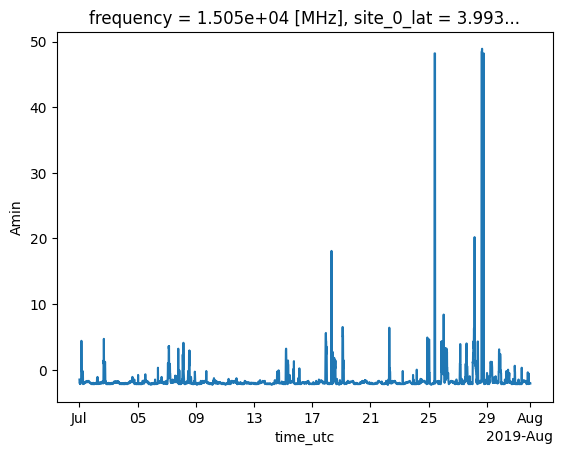

In [ ]:
att_rain = (cml["tsl_max"] - cml["rsl_max"]).to_dataset(name="Amax")
att_rain["Amin"] = cml["tsl_min"] - cml["rsl_min"]
att_rain -= baseline
pia = att_rain - 2.3 # Remove WAA 
pia.Amin.isel(cml_id=0, sublink_id=0).plot()

In [ ]:
pia.isel(cml_id=0, sublink_id=0).max()

<xarray.Dataset> Size: 160B
Dimensions:      ()
Coordinates:
    frequency    float64 8B 1.505e+04
    site_0_lat   float64 8B 3.993
    site_0_lon   float64 8B 9.787
    site_1_lat   float64 8B 3.977
    site_1_lon   float64 8B 9.792
    transmitter  float64 8B 0.0
    length       float64 8B 1.852e+03
    cml_id       <U19 76B '3.984686N-9.789517E'
    sublink_id   <U3 12B '0_0'
Data variables:
    Amax         float64 8B 60.4
    Amin         float64 8B 48.9

In [ ]:
alpha = 0.3
alpha * (0.051700 * (118.3 / 1.852) ** 1.0943) + (1-alpha) * (0.051700 * (106.8 / 1.852) ** 1.0943)

4.5251866333011055

In [ ]:
cfs = alcoba_2019_africa_coefs().sel(frequency=cml.frequency, method="nearest")
cfs

<xarray.Dataset> Size: 39kB
Dimensions:      (cml_id: 126, sublink_id: 6)
Coordinates:
  * cml_id       (cml_id) <U19 10kB '3.984686N-9.789517E' ... '4.095631N-9.74...
  * sublink_id   (sublink_id) <U3 72B '0_0' '0_1' '1_0' '1_1' '2_0' '2_1'
    frequency    (cml_id, sublink_id) float64 6kB 1.5e+04 1.45e+04 ... 2.3e+04
    site_0_lat   (cml_id) float64 1kB 3.993 3.993 3.997 ... 4.087 4.092 4.094
    site_0_lon   (cml_id) float64 1kB 9.787 9.787 9.764 ... 9.766 9.729 9.742
    site_1_lat   (cml_id) float64 1kB 3.977 3.979 3.997 ... 4.095 4.091 4.097
    site_1_lon   (cml_id) float64 1kB 9.792 9.816 9.759 ... 9.764 9.736 9.743
    transmitter  (cml_id, sublink_id) float64 6kB 0.0 1.0 nan ... nan nan nan
    length       (cml_id) float64 1kB 1.852e+03 3.573e+03 556.0 ... 736.0 419.0
Data variables:
    a            (cml_id, sublink_id) float64 6kB 0.0517 0.0473 ... 0.1281
    b            (cml_id, sublink_id) float64 6kB 1.094 1.102 ... 1.043 1.043

In [ ]:
cfs = cfs.drop([c for c in cfs.coords if c not in cfs.dims])
cfs

/tmp/ipykernel_246045/608259543.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  cfs = cfs.drop([c for c in cfs.coords if c not in cfs.dims])


<xarray.Dataset> Size: 22kB
Dimensions:     (cml_id: 126, sublink_id: 6)
Coordinates:
  * cml_id      (cml_id) <U19 10kB '3.984686N-9.789517E' ... '4.095631N-9.742...
  * sublink_id  (sublink_id) <U3 72B '0_0' '0_1' '1_0' '1_1' '2_0' '2_1'
Data variables:
    a           (cml_id, sublink_id) float64 6kB 0.0517 0.0473 ... 0.1281 0.1281
    b           (cml_id, sublink_id) float64 6kB 1.094 1.102 ... 1.043 1.043

In [ ]:
cfs = alcoba_2019_africa_coefs().sel(frequency=pia.frequency, method="nearest")
cfs

<xarray.Dataset> Size: 39kB
Dimensions:      (cml_id: 126, sublink_id: 6)
Coordinates:
  * cml_id       (cml_id) <U19 10kB '3.984686N-9.789517E' ... '4.095631N-9.74...
  * sublink_id   (sublink_id) <U3 72B '0_0' '0_1' '1_0' '1_1' '2_0' '2_1'
    frequency    (cml_id, sublink_id) float64 6kB 1.5e+04 1.45e+04 ... 2.3e+04
    site_0_lat   (cml_id) float64 1kB 3.993 3.993 3.997 ... 4.087 4.092 4.094
    site_0_lon   (cml_id) float64 1kB 9.787 9.787 9.764 ... 9.766 9.729 9.742
    site_1_lat   (cml_id) float64 1kB 3.977 3.979 3.997 ... 4.095 4.091 4.097
    site_1_lon   (cml_id) float64 1kB 9.792 9.816 9.759 ... 9.764 9.736 9.743
    transmitter  (cml_id, sublink_id) float64 6kB 0.0 1.0 nan ... nan nan nan
    length       (cml_id) float64 1kB 1.852e+03 3.573e+03 556.0 ... 736.0 419.0
Data variables:
    a            (cml_id, sublink_id) float64 6kB 0.0517 0.0473 ... 0.1281
    b            (cml_id, sublink_id) float64 6kB 1.094 1.102 ... 1.043 1.043

In [ ]:
cfs = cfs.drop([c for c in cfs.coords if c not in cfs.dims])
cfs

/tmp/ipykernel_246045/608259543.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  cfs = cfs.drop([c for c in cfs.coords if c not in cfs.dims])


<xarray.Dataset> Size: 22kB
Dimensions:     (cml_id: 126, sublink_id: 6)
Coordinates:
  * cml_id      (cml_id) <U19 10kB '3.984686N-9.789517E' ... '4.095631N-9.742...
  * sublink_id  (sublink_id) <U3 72B '0_0' '0_1' '1_0' '1_1' '2_0' '2_1'
Data variables:
    a           (cml_id, sublink_id) float64 6kB 0.0517 0.0473 ... 0.1281 0.1281
    b           (cml_id, sublink_id) float64 6kB 1.094 1.102 ... 1.043 1.043

In [ ]:
#| exporti
def reindex_coefs(
        pia: xr.Dataset, # ds containing path integrated attenuation
        coefs: xr.Dataset # ds containing a and b, k-R law coefficients with frequency dim
    ):
    """Reindex k-R coefficients to match the path integrated attenuation dataset."""
    coefs = coefs.sel(frequency=pia.frequency, method="nearest")
    return coefs.drop([c for c in coefs.coords if c not in coefs.dims])

$H(x)$ is the Heaviside step function, defined as:

$$
H(x) = \begin{cases}
0 & \text{if } x \leq 0 \\
1 & \text{if } x > 0
\end{cases}
$$


In [ ]:
H = pia > 0
H

<xarray.Dataset> Size: 5MB
Dimensions:      (cml_id: 126, sublink_id: 6, time: 2964)
Coordinates:
  * cml_id       (cml_id) <U19 10kB '3.984686N-9.789517E' ... '4.095631N-9.74...
  * sublink_id   (sublink_id) <U3 72B '0_0' '0_1' '1_0' '1_1' '2_0' '2_1'
  * time         (time) datetime64[ns] 24kB 2019-07-01T00:05:00 ... 2019-07-3...
    frequency    (cml_id, sublink_id) float64 6kB 1.505e+04 1.456e+04 ... nan
    site_0_lat   (cml_id) float64 1kB 3.993 3.993 3.997 ... 4.087 4.092 4.094
    site_0_lon   (cml_id) float64 1kB 9.787 9.787 9.764 ... 9.766 9.729 9.742
    site_1_lat   (cml_id) float64 1kB 3.977 3.979 3.997 ... 4.095 4.091 4.097
    site_1_lon   (cml_id) float64 1kB 9.792 9.816 9.759 ... 9.764 9.736 9.743
    transmitter  (cml_id, sublink_id) float64 6kB 0.0 1.0 nan ... nan nan nan
    length       (cml_id) float64 1kB 1.852e+03 3.573e+03 556.0 ... 736.0 419.0
Data variables:
    Amax         (cml_id, sublink_id, time) bool 2MB False False ... False False
    Amin         (cml_id, sublink_id, time) bool 2MB False False ... False False

$$
\langle R_{min | max} \rangle = a \left(\frac{PIA_{min|max}}{L}\right)^b H(PIA_{min|max}) \quad
$$


In [ ]:
Rmin = (cfs.a * (pia["Amin"] / (pia.length / 1e3)) ** cfs.b).where(H["Amin"])
Rmax = (cfs.a * (pia["Amax"] / (pia.length / 1e3)) ** cfs.b).where(H["Amax"])
Rmin, Rmax

(<xarray.DataArray (cml_id: 126, sublink_id: 6, time: 2964)> Size: 18MB
 array([[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 ...
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, na

Finally we can complute $\langle R \rangle$ as a weighted average of $\langle R_{max} \rangle$ and $\langle R_{min} \rangle$:
$$
\langle R \rangle = \alpha \langle R_{max} \rangle + (1 - \alpha) \langle R_{min} \rangle \quad
$$

Overeem et al. (2013) stimated and optimal value of $\alpha=0.33$ by calibrating the model using 12 days of data from the Netherlands. We use this value as a reasonable default; however, it should be calibrated for each specific region and deployment.

[<matplotlib.lines.Line2D>]

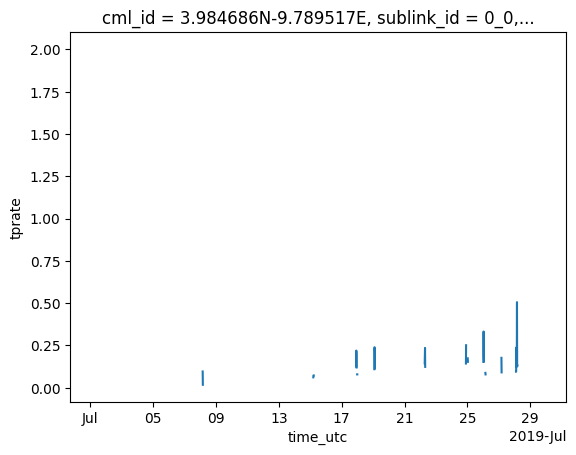

In [ ]:
#| hide
alpha = 0.3
R = (alpha * Rmax + (1 - alpha) * Rmin).to_dataset(name="tprate")
R.isel(cml_id=0, sublink_id=0).tprate.plot()

In [ ]:
#| export
def get_overeem_et_al_2013_min_max_sampling_tprate(
        pia: xr.Dataset, # ds containing path integrated attenuation with Amin and Amax variables
        cfs: xr.Dataset, # ds containing a and b, k-R law coefficients with frequency dim
        alpha: float = 0.3 # weighting factor between max and min sampling rain rates
    ) -> xr.Dataset:
    """Compute the rain rate using the Overeem et al. (2013) min/max sampling approach. """
    def kR(pia, a, b, l):
        return a * (pia / (l / 1e3)) ** b # Convert OpenSense standard length in meters to km
    H = pia > 0
    cfs = reindex_coefs(pia, cfs)

    Rmin = kR(pia["Amin"], cfs.a, cfs.b, pia.length).where(H["Amin"])
    Rmax = kR(pia["Amax"], cfs.a, cfs.b, pia.length).where(H["Amax"])

    tprate = (alpha * Rmax + (1 - alpha) * Rmin).to_dataset(name="tprate")
    tprate["tprate"].attrs = {"long_name": "time_mean_path_averaged_rain_rate", "units": "mm/h"}
    return tprate

In [ ]:
tprate = get_overeem_et_al_2013_min_max_sampling_tprate(pia, alcoba_2019_africa_coefs())
tprate

/tmp/ipykernel_246045/1759363286.py:8: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  return coefs.drop([c for c in coefs.coords if c not in coefs.dims])


<xarray.Dataset> Size: 18MB
Dimensions:      (cml_id: 126, sublink_id: 6, time: 2964)
Coordinates:
  * cml_id       (cml_id) <U19 10kB '3.984686N-9.789517E' ... '4.095631N-9.74...
  * sublink_id   (sublink_id) <U3 72B '0_0' '0_1' '1_0' '1_1' '2_0' '2_1'
  * time         (time) datetime64[ns] 24kB 2019-07-01T00:05:00 ... 2019-07-3...
    frequency    (cml_id, sublink_id) float64 6kB 1.505e+04 1.456e+04 ... nan
    site_0_lat   (cml_id) float64 1kB 3.993 3.993 3.997 ... 4.087 4.092 4.094
    site_0_lon   (cml_id) float64 1kB 9.787 9.787 9.764 ... 9.766 9.729 9.742
    site_1_lat   (cml_id) float64 1kB 3.977 3.979 3.997 ... 4.095 4.091 4.097
    site_1_lon   (cml_id) float64 1kB 9.792 9.816 9.759 ... 9.764 9.736 9.743
    transmitter  (cml_id, sublink_id) float64 6kB 0.0 1.0 nan ... nan nan nan
    length       (cml_id) float64 1kB 1.852e+03 3.573e+03 556.0 ... 736.0 419.0
Data variables:
    tprate       (cml_id, sublink_id, time) float64 18MB nan nan nan ... nan nan

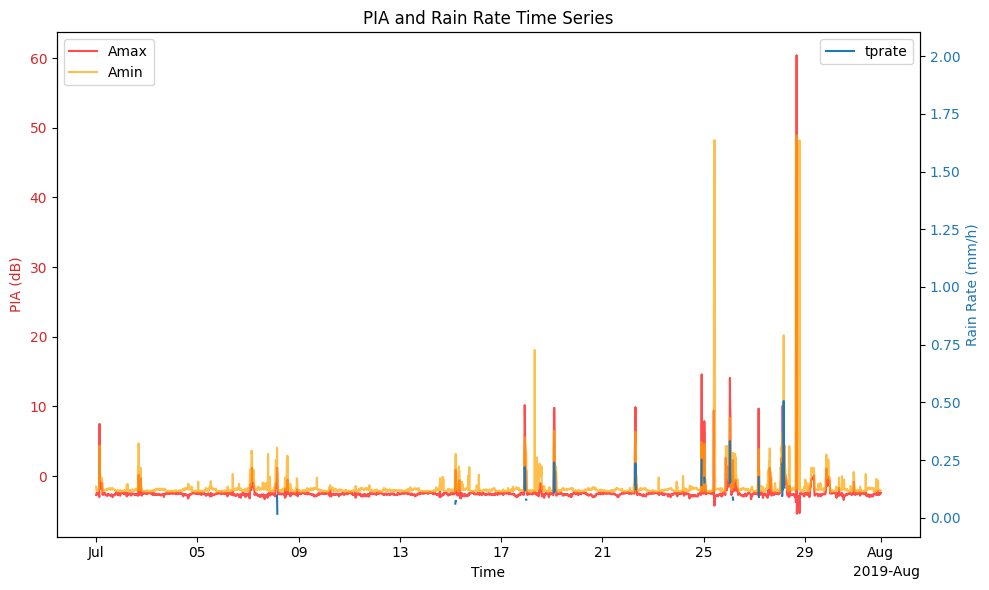

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot PIA variables on left axis
color = 'tab:red'
pia.isel(cml_id=0, sublink_id=0).Amax.plot(ax=ax1, color='red', alpha=0.7, label='Amax')
pia.isel(cml_id=0, sublink_id=0).Amin.plot(ax=ax1, color='orange', alpha=0.7, label='Amin')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax1.set_xlabel('Time')
ax1.set_ylabel('PIA (dB)', color=color)
ax1.set_title("")

# Create second y-axis for tprate
ax2 = ax1.twinx()
color = 'tab:blue'
tprate.isel(cml_id=0, sublink_id=0).tprate.plot(ax=ax2, color=color, alpha=1, label='tprate')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')
ax2.set_ylabel('Rain Rate (mm/h)', color=color)

plt.title('PIA and Rain Rate Time Series')
plt.tight_layout()
plt.show()

#### References

- Alcoba Kait, M. 2019. A contribution to rainfall observation in Africa from polarimetric weather radar and commercial microwave links. Ph.D. dissertation, Université Paul Sabatier – Toulouse III, 202 pages. https://tel-02955598 (accessed 2025‑11‑21).
- Overeem, A., H. Leijnse, and R. Uijlenhoet, 2013: Country-wide rainfall maps from cellular communication networks. Proceedings of the National Academy of Sciences, 110, 2741–2745, doi:10.1073/pnas.1217961110.
- Chwala, C., and H. Kunstmann, 2019: Commercial Microwave Link Networks for rainfall observation: Assessment of the current status and future challenges. WIREs Water, 6, doi:10.1002/wat2.1337. 

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()